# MCMC-GMM inference of vortices from pressure

In [1]:
using Revise

In [2]:
using LowRankVortex

[ Info: Precompiling LowRankVortex [fdf095b8-6f21-420b-9d49-8e692abb03d1]


In [3]:
using PotentialFlow

In [4]:
using CairoMakie
#using Plots
#pyplot()

In [5]:
using LaTeXStrings

In [6]:
using Distributions
using Random
using LinearAlgebra
using GaussianMixtures
using Statistics

### Truth

In [108]:
δ_true = 0.01


#=
# For placing the vortices randomly
=#
#=
Nv_cluster = 5
Nv_per_cluster = 1
Nv_true = Nv_cluster*Nv_per_cluster 

xr = (-1.5,1.5)
yr = (-1.0,1.0)
Γr = (-2.0,2.0)

σx = 0.03
σΓ = 0.03
zv, Γv = createclusters(Nv_cluster,Nv_per_cluster,xr,yr,Γr,σx,σΓ,each_cluster_radius=1.5*σx)
=#

#=
Prescribed placement
=#
#zv = [0.5+1.0im]
#Γv = [1.0]
#zv = [-0.58+0.75im,0.33+0.5im]  # [-1.0+0.75im,0.75+0.5im]
#Γv = [1.2,0.4] #[1.2,0.4] #[1.2,-1.0]
zv = [-0.75+0.75im,0.25+0.5im,0.75+0.75im]
Γv = [1.0,-1.2,1.4]
Nv_true = length(zv);

#=
x_true = [-0.7611581857580003,
  0.7266716391085539,
  0.04730897238217636,
  0.4637373841856715,
  0.6347931827658125,
  1.6466841098688845];
  zv, Γv = state_to_positions_and_strengths(x_true)
  Nv_true =  length(zv)
=#


### Set some plotting themes

In [109]:
xytheme = Theme(
        Axis = (aspect=DataAspect(),xlabel=L"x",ylabel=L"y"),
        palette = (color = Makie.wong_colors(),),
        Lines = (cycle = [:color],),
        Scatter = (cycle = [:color],)
    );

sensortheme = Theme(
    Axis = (xlabel="Sensor no.",ylabel=L"p-p_\infty") # xticks=1:length(sens),
);

#### Set up the observer for the truth data

In [110]:
config_true, x_true = get_config_and_state(zv,Γv;δ=δ_true)

ϵmeas_data = [1e-5,1e-4,2.5e-4,3.75e-4,5e-4,6.25e-4,8e-4,1e-3,1.5e-3,2e-3,3e-3,4e-3];

## Vortex estimation

In [111]:
Nv_estimator = 3
δ = 0.01

config_estimator = VortexConfig(Nv_estimator, δ, body=LowRankVortex.NoWall)


# ranges to confine the prior mean to
xr = (-2,2)
yr = (0.01,4) #(0.01,4) #(0.01,2.0)
#dΓr = (-4,4)
#Γtotr = (0.01,2)
Γr = (-2,2)
bounds = create_state_bounds(xr,yr,Γr,config_estimator);

### Set up the MCMC parameters

In [125]:
## Parallel tempering ##
propvarX_coarse = 0.01^2 
propvarY_coarse = 0.01^2
propvarΓ_coarse = 0.01^2 #0.05^2

propvarX_fine = 0.005^2 # 0.01^2
propvarY_fine = 0.005^2 # 0.01^2
propvarΓ_fine = 0.005^2 # 0.005^2 # 0.01^2

Ntrial = [10000, 600000]
propvar = [state_covariance(propvarX_coarse,propvarY_coarse,propvarΓ_coarse,config_estimator),
           state_covariance(propvarX_fine,propvarY_fine,propvarΓ_fine,config_estimator)];

### Loop through cases

In [120]:
#=
gm4_array = GMM[]
Ns4_array = Int[]
ϵ4_array = Float64[]
for ϵmeas in ϵmeas_data
    for Nsens in 4:4
        @info "Parameters" Nsens ϵmeas
        obs_true, ystar, H, Σϵ, Σx = get_truth_data(Nsens,ϵmeas,x_true,config_true)
        logp̃_fcn, obs = setup_estimator(obs_true.sens,bounds,config_estimator,ystar,Σϵ)

        #logp̃_fcn, obs, _ = setup_for_sensors(Nsens,ϵmeas)
        xseed = generate_random_state(bounds,obs.config)

        gm, x_decorr_data = find_gmm(1,logp̃_fcn,obs,xseed,Ntrial,propvar)
        push!(gm4_array,deepcopy(gm))
        push!(Ns4_array,Nsens)
        push!(ϵ4_array,ϵmeas)
    end
end
=#

### For two sensors
There is a circular manifold of possible solutions. Create this circle here (`zc`)

In [42]:
#=
# The circle of solutions with 2 sensors
logp̃_fcn, obs, _ = setup_for_sensors(2,ϵmeas_data[5])

z0 = x_true[x_id] + im*x_true[y_id]
s = [obs.sens[1],obs.sens[end]]

cent = (abs2(z0-s[1])*s[2] - abs2(z0-s[2])*s[1])/(abs2(z0-s[1]) - abs2(z0-s[2]))
rad2 = abs2(z0-s[1])*abs2(z0-s[2])*abs2(s[1]-s[2])/(abs2(z0-s[1]) - abs2(z0-s[2]))^2

dzdΓ = 0.5*im/x_true[Γ_id]*(abs2(z0-s[2]) - abs2(z0-s[1]))*(z0-cent)/imag(conj(s[2]-s[1])*z0)
dxdΓ = [real(dzdΓ),imag(dzdΓ),1.0]
dxdΓ /= norm(dxdΓ)

θ = range(0,2π,length=100)
zc = cent .+ sqrt(rad2)*exp.(im*θ);
=#

LoadError: UndefVarError: x_id not defined

Some of the types have been truncated in the stacktrace for improved reading. To emit complete information
in the stack trace, evaluate `TruncatedStacktraces.VERBOSE[] = true` and re-run the code.


### Generate results for a specific case

In [126]:
K = 8
Nsens = 11
ϵmeas = 5e-4
obs_true, ystar, H, Σϵ, Σx = get_truth_data(Nsens,ϵmeas,x_true,config_true)
logp̃_fcn, obs = setup_estimator(obs_true.sens,bounds,config_estimator,ystar,Σϵ)

xseed = generate_random_state(bounds,obs.config)
gm, x_decorr_data = find_gmm(K,logp̃_fcn,obs,xseed,Ntrial,propvar);

K-means converged with 36 iterations (objv = 403.2579703704817)


[ Info: Initializing GMM, 8 Gaussians diag covariance 9 dimensions using 3001 data points
┌ Info: K-means with 3001 data points using 36 iterations
└ 37.5 data points per parameter


In [127]:
xm, Σ, wts = means_and_covariances(gm,config_estimator);

Σ_0 = state_covariance(δ^2,δ^2,0.0,config_estimator);
Σv = [Σ[j] .+ Σ_0 for j = 1:length(Σ)]; # add the blob size to the covariance for vorticity field

In [128]:
plottype = :samples
#plottype = :vorticity

saveplot = false

ds_string = string(1000+round(Int,100*abs(obs.sens[end]-obs.sens[1])/(length(obs.sens)-1)))[2:end]
ns_string = string(length(obs.sens))
nv_string = string(obs.config.Nv)
K_string = string(K)

delta_string = string(round(Int,1000+100*δ_true))[2:4]

filename = nv_string*"vortex-3truth-K"*K_string*"-delta"*delta_string*"-"*ns_string*"sensor-ds"*ds_string*"-noise5em4"
#filename = nv_string*"vortex-1truth-K"*K_string*"-delta"*delta_string*"-"*ns_string*"sensorcirc-ds"*ds_string*"-noise5em4"

"3vortex-3truth-K8-delta001-11sensor-ds020-noise5em4"

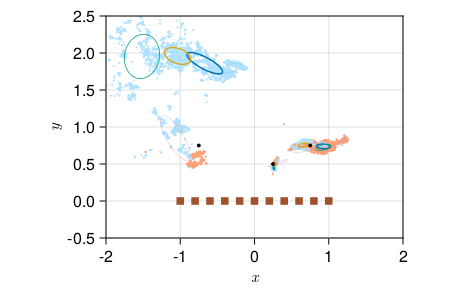

In [129]:
with_theme(xytheme) do
    f = Figure(;resolution=(450,300))
    ax = f[1,1] = Axis(f)

    if plottype == :samples
        show_singularity_samples!(ax,x_decorr_data,obs,nskip=1,markersize=3) #colormap=:Set1_3:RdBu_3,nskip=1)
        #singularity_ellipses!(ax,xm[:,best_comp],Σ[best_comp],obs,color=:red)
        singularity_ellipses!(ax,xm,Σ,wts,obs)
        
        # Draw some lines to indicate maximum uncertainty direction at true state
        #=
        xid, yid, Γid = get_singularity_ids(obs_true.config)
        F = eigen(Σx)
        vmax = F.vectors[:,end]
        for j = 1:number_of_singularities(obs_true.config)
            lines!(ax,[real(zv)[j]-vmax[xid[j]],real(zv)[j]+vmax[xid[j]]],[imag(zv)[j]-vmax[yid[j]],imag(zv)[j]+vmax[yid[j]]],color=:black,linewidth=0.5)
        end
        =#
    
    elseif plottype == :vorticity
        wmin, wmax = -0.2,0.2
        lev = range(wmin,wmax,length=20)
        plot_expected_sourcefield!(ax,xm,Σv,wts,obs,xlims=(-2,2),ylims=(-1,2.5),colormap=cgrad(:lighttemperaturemap,rev=true),linewidth=2,colorrange=(wmin,wmax),levels=lev)
        #plot_expected_sourcefield!(ax,xm[:,best_comp],Σ[best_comp],obs,ylims=(-1,2.5),colormap=:lighttemperaturemap,linewidth=2,levels=range(-1,1,length=14))

        Σ_true = state_covariance(δ_true^2,δ_true^2,0.0,config_true);        
        plot_expected_sourcefield!(ax,x_true,Σ_true,obs_true,ylims=(-1,2),colormap=cgrad(:lighttemperaturemap,rev=true),linestyle=:dot,linewidth=1,colorrange=(wmin,wmax),llevels=lev)
        
    end
    
    #lines!(ax,real(zc),imag(zc);marker=:none,color=:gray)
    #lines!(ax,[0.0,real(z0)],[0.0,imag(z0)],marker=:none,color=:gray)

    scatter!(ax,real(zv),imag(zv),marker=:circle,markersize=4,color=:black,strokewidth=1)
  
    plot_sensors!(ax,obs,color=:sienna)
    #ylims!(ax,(-0.5,2))
    #xlims!(ax,(-1.5,1.5))
    ylims!(ax,(-0.5,2.5))
    xlims!(ax,(-2,2))
    
    fullname = String(plottype)*"-"*filename*".svg" 
    saveplot && save(fullname,f)
    f
end

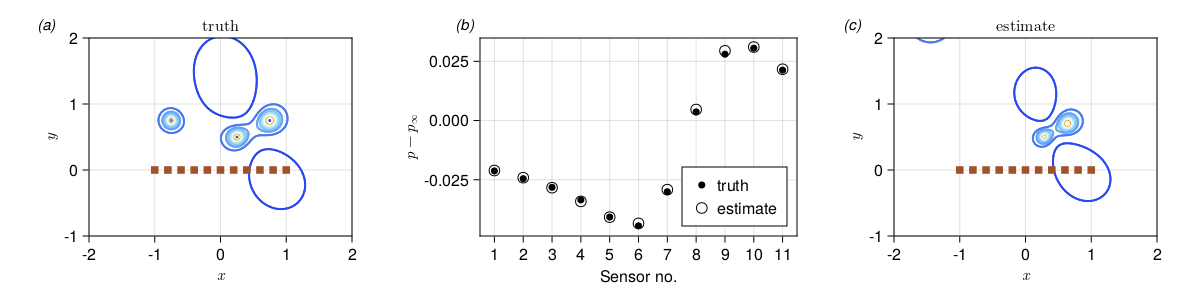

In [118]:
t = 0.0
_, best_comp = findmax(wts)
l = range(-0.5,0.01,length=21)
cl = (-0.5,0.01)
f = Figure(;resolution=(1200,300))
ga = f[1, 1] = GridLayout()
gb = f[1, 2] = GridLayout()
gc = f[1, 3] = GridLayout()
axleft = Axis(ga[1,1];xlabel=L"x",ylabel=L"y",limits=(-2,2,-1,2),aspect=DataAspect(),title=L"\textrm{truth}")
axright = Axis(gc[1,1];xlabel=L"x",ylabel=L"y",limits=(-2,2,-1,2),aspect=DataAspect(),title=L"\textrm{estimate}")
linkaxes!(axright,axleft)
pmin, pmax = -5,0.01
plot_pressure_field!(axleft,x_true,obs_true,colormap=cgrad(:lighttemperaturemap,rev=true),colorrange=(pmin,pmax),levels=range(pmin,pmax,length=15),linewidth=2)
plot_sensors!(axleft,obs_true,color=:sienna)
plot_pressure_field!(axright,xm[:,best_comp],obs,mode=:relative,colormap=cgrad(:lighttemperaturemap,rev=true),colorrange=(pmin,pmax),levels=range(pmin,pmax,length=15),linewidth=2)
plot_sensors!(axright,obs,color=:sienna)


# Sensor plot
axcenter = Axis(gb[1,1];xticks=1:length(obs.sens),xlabel="Sensor no.",ylabel=L"p-p_\infty") 
plot_sensor_data!(axcenter,ystar,xm[:,best_comp],t,obs;sensor_noise=ϵmeas*ones(length(ystar)))
axislegend(axcenter,position=:rb)


for (label, layout) in zip(["(a)", "(b)", "(c)"], [ga, gb, gc])
    Label(layout[1, 1, TopLeft()], label,
        fontsize = 15,
        font = "TeX Heros Italic",
        padding = (0, 5, 5, 0),
        halign = :right)
end
saveplot && save("pressurefield-"*filename*".svg",f)

f

### Plot covariances

In [148]:
Σ4_array = Matrix[]
xm4_array = Matrix[]
wts4_array = Float64[]
for gm in gm4_array
    xm, Σ, wts = means_and_covariances(gm,config_estimator)
    push!(xm4_array,deepcopy(xm))
    push!(Σ4_array,deepcopy(Σ[1]))
    push!(wts4_array,deepcopy(wts[1]))
end

In [82]:
x_id, y_id, Γ_id = get_singularity_ids(1,config_estimator)

(1, 2, 3)

In [149]:
# varying noise levels
ϵ = ϵ4_array[Ns4_array.==4]
Σ = Σ4_array[Ns4_array.==4]
λ1 = map(Σj -> eigen(Σj).values[1],Σ)
λ2 = map(Σj -> eigen(Σj).values[2],Σ)
λ3 = map(Σj -> eigen(Σj).values[3],Σ)

12-element Vector{Float64}:
 4.921006717240011e-6
 0.0004437522716796398
 0.003108372679460184
 0.00677170133892477
 0.013392983580305927
 0.026020371774627467
 0.06341514521672803
 0.12458755101732785
 0.2905768682605969
 0.3096226022044285
 0.35378168314802616
 0.5494957957996457

In [188]:
# varying number of sensors
Ns = Ns_array[ϵ_array.==5e-4]
Σ = Σ_array[ϵ_array.==5e-4]
λ1 = map(Σj -> eigen(Σj).values[1],Σ)
λ2 = map(Σj -> eigen(Σj).values[2],Σ)
λ3 = map(Σj -> eigen(Σj).values[3],Σ)

5-element Vector{Float64}:
 0.4396233639673928
 0.04301967153210292
 0.014315931603408787
 0.011954884183194365
 0.010335621247728357

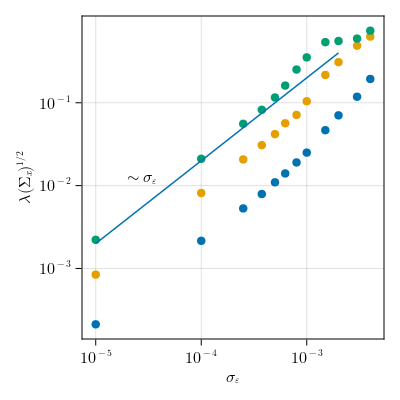

In [155]:
f = Figure(;resolution=(400,400))
ax = f[1,1] = Axis(f;yscale=log10,xscale=log10,xlabel=L"\sigma_{\epsilon}",ylabel=L"\lambda(\Sigma_x)^{1/2}",
                                  yticks=([1e-3,1e-2,1e-1],[L"10^{-3}",L"10^{-2}",L"10^{-1}"]),
                                  xticks=([1e-5,1e-4,1e-3],[L"10^{-5}",L"10^{-4}",L"10^{-3}"]))

scatter!(ax,ϵ,sqrt.(λ1))
scatter!(ax,ϵ,sqrt.(λ2))
scatter!(ax,ϵ,sqrt.(λ3))
#xlims!(ax,(1e-6,2.25e-3))
#ylims!(ax,(1e-4,1e0))

ϵ_2pt = [1e-5,2e-3]
lines!(ax,ϵ_2pt,(2e-2/1e-4).*ϵ_2pt,marker=:none)
text!(ax,2e-5,1e-2,text=L"\sim \sigma_{\epsilon}")
save("covar-eigen-vs-noise-1vortex-4sensor.svg",f)
f

In [154]:
f = Figure(;resolution=(400,400))
ax = f[1,1] = Axis(f;yscale=log10,xlabel=L"N_s",ylabel=L"\lambda^{1/2}")

scatter!(ax,Ns,sqrt.(λ1))
scatter!(ax,Ns,sqrt.(λ2))
scatter!(ax,Ns,sqrt.(λ3))
#xlims!(ax,(2e-4,1.2e-3))
ylims!(ax,(2e-3,1e0))
save("covar-eigen-vs-sensors-1vortex-noise5em4.svg",f)
f

LoadError: UndefVarError: Ns not defined

Some of the types have been truncated in the stacktrace for improved reading. To emit complete information
in the stack trace, evaluate `TruncatedStacktraces.VERBOSE[] = true` and re-run the code.
